- 3 different exercises: sitting, standing and walking in the muscles: biceps femoris, vastus medialis, rectus femoris and semitendinosus addition to goniometry in the exercises.

Each data file contains 5 columns, organized as follows.
Segment	Lower Limb
Channel	Ch1	Ch2	Ch3	Ch4	Ch5
Muscle	RF	BF	VM	ST	FX
Column	0	1	2	3	4


- 2.1. Protocol:
22 male subjects , 11 with different knee abnormalities previously diagnosed by a professional. They undergo three movements to analyze the behavior associated with the knee muscle , gait , leg extension from a sitting position , and flexion of the leg up. The acquisition process was conducted with 4 electrodes ( Vastus Medialis , semitendinosus , biceps femoris and rectus femoris ) and the goniometer in the knee .

- 2.2.	Instrumentation
Datalog equipment was used MWX8 by Biometrics of 8 digital channels and 4 analog channels , of which 4 for sampling were used SEMG and 1 for goniometry, these data were acquired directly to the computer MWX8 internal storage with microSD card and transmitted in Real-time Datalog software through bluetooth adapter , 14-bit resolution and sampling frequency of 1000Hz .

- 2.3.	Data configuration:
The total number of electrodes is 4, corresponding to the time series one for each channel (1 to 4). Each series contains ~ 5 shares or motion repetitions for each subject.

## No sessions exist

In [2]:
import numpy as np
import pandas as pd
import sys, os
from collections import defaultdict

def call_data(base_path, sub_lst, sub_idx):
    data = pd.read_csv(base_path+sub_lst[sub_idx])
    return data


path_abnormal = "../../../Data/Gait1/Abnormal/"
path_normal = "../../../Data/Gait1/normal/"

lst_abnormal = os.listdir(path_abnormal)
lst_normal = os.listdir(path_normal)

# Intra-subject

### Obj. 1
1. Subject 별로 train-test split 써서 학습 / 테스트
2. feature extraction using multiple features / windows
- use normal only

### Obj. 2
- Cross-subject 시에 사용 가능 -> few-shot adaptation

### Obj. 3
- Federated Learning with multiple subjects

In [12]:
import numpy as np
from collections import defaultdict

def sliding_window(data, window_size, step_size):
    """ 슬라이딩 윈도우 분할 """
    num_samples, num_channels = data.shape
    windows = []
    for start in range(0, num_samples - window_size + 1, step_size):
        end = start + window_size
        windows.append(data[start:end, :])  # (window_size, num_channels)
    return np.array(windows)  # (num_windows, window_size, num_channels)

# --- Feature extraction ---
def extract_features(window):
    """ 한 윈도우 (window_size, num_channels) -> feature 벡터 """
    feats = []
    for ch in range(window.shape[1]):
        x = window[:, ch]

        # Time-domain features
        mav = np.mean(np.abs(x))  # Mean Absolute Value
        rms = np.sqrt(np.mean(x**2))  # RMS
        var = np.var(x)  # Variance
        wl = np.sum(np.abs(np.diff(x)))  # Waveform Length

        # Simple freq-domain (using FFT)
        fft_vals = np.fft.rfft(x)
        fft_freq = np.fft.rfftfreq(len(x), d=1.0)  # 샘플링 주파수에 맞춰 수정 가능
        psd = np.abs(fft_vals)**2
        mnf = np.sum(fft_freq * psd) / np.sum(psd)  # Mean Frequency

        # Feature 벡터에 추가
        feats.extend([mav, rms, var, wl, mnf])
    return np.array(feats)  # (num_features,)

# --- Main loop ---
subjects_data = defaultdict(list)
subjects_label = defaultdict(list)

window_size = 200   # 샘플 단위 (예: 200 samples ≈ 200ms if fs=1000Hz)
step_size = 10     # 50% overlap

for s_idx, filename in enumerate(lst_normal):
    name = filename.lower()
    subject_id = name.split("n")[0]
    data = call_data(path_normal, lst_normal, s_idx).to_numpy()  # (num_samples, num_channels)

    # 슬라이딩 윈도우 적용: (num_windows, window_size, num_channels)
    windows = sliding_window(data, window_size, step_size)

    # CNN 입력 형태 맞추기: (num_windows, 1, window_size, num_channels)
    windows = np.expand_dims(windows, axis=1)

    # 레이블 지정
    if "standing" in name:
        label = 0
    elif "gait" in name:
        label = 1
    elif "sitting" in name:
        label = 2
    else:
        label = -1

    labels = np.full(len(windows), label)  # 윈도우 개수만큼 같은 라벨

    subjects_data[subject_id].append(windows)  # (num_windows, 1, window_size, num_channels)
    subjects_label[subject_id].append(labels)   # (num_windows,)


In [13]:
subjects_data['1'][0].shape, subjects_data['1'][1].shape, subjects_data['1'][2].shape

((549, 25), (1511, 25), (1433, 25))

Feature shape: (421, 25, 5)


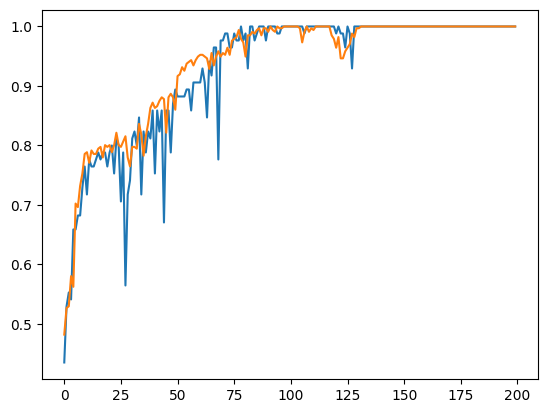

In [26]:
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ---------- Sliding Window ----------
def sliding_window(data, window_size=200, step=100):
    """data shape: (samples, channels)"""
    windows = []
    for start in range(0, data.shape[0] - window_size + 1, step):
        end = start + window_size
        windows.append(data[start:end, :])
    return np.array(windows)  # (num_windows, window_size, channels)

# ---------- Feature Extraction ----------
def extract_features(window):
    """window shape: (window_size, channels)"""
    features = []
    for ch in range(window.shape[1]):
        x = window[:, ch]

        rms = np.sqrt(np.mean(x ** 2))       # Root Mean Square
        mav = np.mean(np.abs(x))             # Mean Absolute Value
        var = np.var(x)                      # Variance
        wl = np.sum(np.abs(np.diff(x)))      # Waveform Length
        zc = np.sum(np.diff(np.sign(x)) != 0)  # Zero Crossing count

        features.append([rms, mav, var, wl, zc])

    return np.array(features)  # shape: (channels, num_features)

# ---------- Dataset Construction ----------
all_X, all_y = [], []

for subject_id in subjects_data.keys():
    data_list = subjects_data[subject_id]
    label_list = subjects_label[subject_id]

    for data, labels in zip(data_list, label_list):   # labels: (num_windows,)
        windows = sliding_window(data, window_size=200, step=100)  # (num_windows, win_len, ch)

        for w, label in zip(windows, labels):
            feat = extract_features(w)   # (channels, num_features)
            all_X.append(feat)
            all_y.append(label)

all_X = np.array(all_X)   # (N, channels, features)
all_y = np.array(all_y)

print("Feature shape:", all_X.shape)  # e.g., (N, 5, 5) → N samples, 5 channels, 5 features

# ---------- Train/Test Split ----------
X_train, X_test, y_train, y_test = train_test_split(all_X, all_y, test_size=0.2, random_state=42)

# reshape for CNN input: (N, channels, features, 1)
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# ---------- Simple CNN Model ----------
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation="relu", input_shape=(all_X.shape[1], all_X.shape[2], 1), padding="same"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation="relu"),
    layers.Dense(len(np.unique(all_y)), activation="softmax")
])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# ---------- Training ----------
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=200, batch_size=64, verbose=0)

plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.show()